<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, datasets
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
path = './data/'
emb_data = pd.read_csv('./data/node2vec_v2_train.csv.gz',compression = 'gzip',sep='\t')
emb_data= emb_data.drop(columns=['Unnamed: 0'])
emb_data.head()
cols = ["is_dorm","is_year","year_diff", "from_high_school",
            "to_high_school", "from_major", "to_major", "is_faculty",
            "is_gender",'label']
emb_data = emb_data.sample(n=200)
X =  emb_data.drop(columns=cols).values
y = emb_data['label'].values


,is_dorm,is_year,year_diff,from_high_school,to_high_school,from_major,to_major,is_faculty,is_gender,d0,...,d59,d6,d60,d61,d62,d63,d7,d8,d9,label
0,0,0,1.000000,17819,50093,265,294,1,1,0.586327,...,0.080709,0.663903,0.521325,-1.218457,0.572862,8.867662,0.098672,0.072862,1.136375,0
1,0,1,0.000000,10070,24562,51,60,1,1,1.556291,...,2.682853,-0.022940,-0.371618,-0.987022,1.831474,-0.448014,1.167990,2.401762,0.431279,0
2,0,1,0.000000,1544,6122,14,39,1,1,-0.649554,...,6.857399,-0.348564,2.753245,-0.207652,1.892210,-0.977367,11.321891,2.510515,2.910005,1
3,0,0,2.196375,1894,50410,0,40,0,0,3.757138,...,5.611234,-1.006211,-1.872412,-0.861397,0.114388,-1.096610,-4.892152,-3.294941,0.133597,0
4,0,1,0.000000,3535,21037,238,271,1,1,1.290842,...,0.824280,0.429348,2.083774,0.281935,-1.777484,0.258835,0.234619,-0.287869,2.079238,0


In [3]:
X = StandardScaler().fit_transform(X)
X.shape

(200, 64)

In [4]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(
    data=principalComponents,
    columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.Series(emb_data['label'].values)], axis = 1,ignore_index=True)


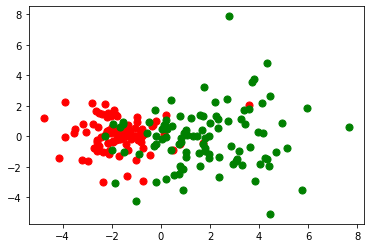

In [5]:
colors = ['r', 'g']
for i, color in enumerate(colors):
    indicesToKeep = finalDf[2] == i
    plt.scatter(finalDf.loc[indicesToKeep, 0],
               finalDf.loc[indicesToKeep, 1],
               c=color,
               s=50)


(200, 64)
(200, 1)


Text(0.5, 0, 'Number of samples')

Text(0, 0.5, 'LDA Component')

Text(0.5, 1.0, 'Embedding dataset (samples = 200)')

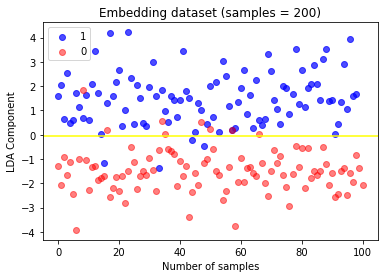

In [6]:
print(X.shape)
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit(X, y).transform(X)
print(X_lda.shape)
ones = y==1
zeros = y==0

plt.scatter(x=list(range(X_lda[ones].shape[0])),y=X_lda[ones],c='b',alpha=0.7,label='1')
plt.scatter(x=list(range(X_lda[zeros].shape[0])),y=X_lda[zeros],c='r',alpha=0.5,label='0')
plt.axhline(lda.intercept_,color='yellow')
plt.xlabel("Number of samples")
plt.ylabel("LDA Component")
plt.legend(loc='best')
plt.title('Embedding dataset (samples = 200)')
plt.savefig('emblda')
plt.show()

In [7]:
print("1:",sum(X_lda[ones]> lda.intercept_),"0:",sum(X_lda[zeros]< lda.intercept_))
print ("accuracy:", (sum(X_lda[ones]> lda.intercept_) + sum(X_lda[zeros]<lda.intercept_))/200)

1: [95] 0: [93]
accuracy: [0.94]


In [8]:
path = './data/'
top_data = pd.read_csv('./data/topological_train_filtered.data', sep='\t')
top_data.head()

top_data = top_data.sample(n=200)
X = top_data.drop(columns=['label']).values
y = top_data['label'].values

X = StandardScaler().fit_transform(X)
X.shape

,preferential,jaccard,adamic adar,resource allocation,is_dorm,is_year,from_major,to_major,is_faculty,label
0,58158.0,0.132609,472.561963,14701.0,0.0,1.0,53.0,106.0,0.0,1.0
1,9918.0,0.010050,16.354318,732.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10058.0,0.041451,53.649231,1032.0,0.0,0.0,246.0,269.0,1.0,1.0
3,10728.0,0.000000,0.000000,0.0,0.0,0.0,1.0,6.0,0.0,0.0
4,214.0,0.000000,0.000000,0.0,0.0,0.0,135.0,160.0,1.0,0.0


(200, 9)

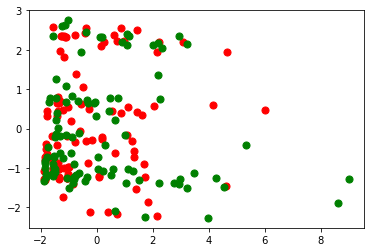

In [9]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(
    data=principalComponents,
    columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.Series(emb_data['label'].values)], axis = 1,ignore_index=True)

colors = ['r', 'g']
for i, color in enumerate(colors):
    indicesToKeep = finalDf[2] == i
    plt.scatter(finalDf.loc[indicesToKeep, 0],
               finalDf.loc[indicesToKeep, 1],
               c=color,
               s=50)

(200, 9)
(200, 1)


Text(0.5, 0, 'Number of samples')

Text(0, 0.5, 'LDA Component')

Text(0.5, 1.0, 'Topological dataset (samples = 200)')

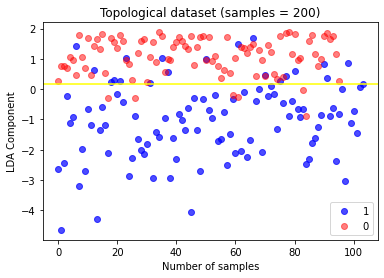

In [10]:
print(X.shape)
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit(X, y).transform(X)
print(X_lda.shape)
ones = y==1
zeros = y==0
plt.scatter(x=list(range(X_lda[ones].shape[0])),y=X_lda[ones],c='b',alpha=0.7,label='1')
plt.scatter(x=list(range(X_lda[zeros].shape[0])),y=X_lda[zeros],c='r',alpha=0.5,label='0')
plt.axhline(lda.intercept_,color='yellow')
plt.xlabel("Number of samples")
plt.ylabel("LDA Component")
plt.legend(loc='best')
plt.title('Topological dataset (samples = 200)')
plt.savefig('toplda')
plt.show()

In [11]:
print("1:",sum(X_lda[ones]< lda.intercept_),"0:",sum(X_lda[zeros]>lda.intercept_))
print ("accuracy:", (sum(X_lda[ones]< lda.intercept_) + sum(X_lda[zeros]>lda.intercept_))/200)

1: [84] 0: [90]
accuracy: [0.87]
